# CLIPP-DistilBERT Model Evaluation

This notebook evaluates the trained CLIPP model (with DistilBERT text encoder) on image-text retrieval tasks. We'll compute:
- Top-1/5/10 retrieval metrics on validation set
- Top-1/5/10 retrieval metrics on training set
- Example retrievals for qualitative assessment

In [1]:
# Import libraries
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Optional, Tuple

from transformers import DistilBertTokenizer
from PIL import Image

# Import our model and config
import sys
sys.path.append('..')
from config import CFG
from training import CLIPModel, ImageTextDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load model and checkpoint
model = CLIPModel().to(device)
model.eval()

ckpt_path = "./checkpoints/best_clipp_bert.pth"
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded checkpoint from epoch {ckpt['epoch']} with val_loss {ckpt['val_loss']:.4f}")

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

Loaded checkpoint from epoch 9 with val_loss 2.6796


In [3]:
# Load datasets
train_df = pd.read_csv("../../data/alpaca_mbj_bandgap_train.csv")
val_df = pd.read_csv("../../data/alpaca_mbj_bandgap_test.csv")

train_ds = ImageTextDataset(train_df, tokenizer, train=False)  # No augmentation during evaluation
val_ds = ImageTextDataset(val_df, tokenizer, train=False)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Training examples: {len(train_ds)}")
print(f"Validation examples: {len(val_ds)}")

Training examples: 5000
Validation examples: 1000


In [4]:
# Helper function to compute embeddings
def compute_embeddings(model, dataloader, device):
    """Compute image and text embeddings for a dataset."""
    model.eval()
    all_img_embs = []
    all_txt_embs = []
    all_captions = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Computing embeddings'):
            # Move everything to device except captions
            batch_on_device = {k: v.to(device) for k, v in batch.items() if k != 'caption'}
            
            # Get image embeddings
            image_features = model.image_encoder(batch_on_device['image'])
            image_embeddings = model.image_projection(image_features)
            
            # Get text embeddings
            text_output = model.text_encoder(
                input_ids=batch_on_device['input_ids'],
                attention_mask=batch_on_device['attention_mask']
            )
            text_embeddings = model.text_projection(text_output.last_hidden_state[:, 0, :])
            
            # Normalize embeddings
            image_embeddings = F.normalize(image_embeddings, dim=-1)
            text_embeddings = F.normalize(text_embeddings, dim=-1)
            
            all_img_embs.append(image_embeddings.cpu())
            all_txt_embs.append(text_embeddings.cpu())
            all_captions.extend(batch['caption'])
    
    return torch.cat(all_img_embs), torch.cat(all_txt_embs), all_captions

def compute_retrieval_metrics(img_embs, txt_embs, k=10):
    """Compute Top-k retrieval metrics."""
    # Compute similarity matrix
    similarity = img_embs @ txt_embs.t()
    
    # For each row, get top k indices
    _, indices = similarity.topk(k=k, dim=1)
    
    # Labels are diagonal (index should match position)
    labels = torch.arange(len(img_embs)).view(-1, 1)
    
    # Compute metrics
    top1 = (indices[:, :1] == labels).float().mean()
    top5 = (indices[:, :5] == labels).any(dim=1).float().mean()
    top10 = (indices[:, :10] == labels).any(dim=1).float().mean()
    
    return {
        'top1': top1.item(),
        'top5': top5.item(),
        'top10': top10.item()
    }

# Compute Validation Set Metrics

Let's first evaluate on the validation set to get Top-1/5/10 retrieval metrics.

In [5]:
# Compute validation embeddings
val_img_embs, val_txt_embs, val_captions = compute_embeddings(model, val_loader, device)

# Compute validation metrics
print("Computing validation metrics...")
val_metrics = compute_retrieval_metrics(val_img_embs, val_txt_embs)
print("\nValidation Metrics:")
for k, v in val_metrics.items():
    print(f"{k}: {v:.4f}")

Computing embeddings: 100%|██████████| 32/32 [00:06<00:00,  5.19it/s]



Computing validation metrics...

Validation Metrics:
top1: 0.0400
top5: 0.1430
top10: 0.2120


# Compute Training Set Metrics

Now let's compute the same metrics on the training set to check for overfitting.

In [6]:
# Compute training embeddings
train_img_embs, train_txt_embs, train_captions = compute_embeddings(model, train_loader, device)

# Compute training metrics
print("Computing training metrics...")
train_metrics = compute_retrieval_metrics(train_img_embs, train_txt_embs)
print("\nTraining Metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

Computing embeddings: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]



Computing training metrics...

Training Metrics:
top1: 0.0202
top5: 0.0764
top10: 0.1330


# Example Retrievals

Let's look at some example retrievals from the validation set to qualitatively assess the model.

In [7]:
def show_retrievals(query_idx, img_embs, txt_embs, texts, k=5):
    """Show top-k retrievals for a query image or text."""
    with torch.no_grad():
        # Get query embeddings
        q_img = img_embs[query_idx]
        q_txt = txt_embs[query_idx]
        
        # Compute similarities
        img2txt = q_img @ txt_embs.t()
        txt2img = q_txt @ img_embs.t()
        
        # Get top-k indices
        _, i2t_idx = torch.topk(img2txt, k)
        _, t2i_idx = torch.topk(txt2img, k)
        
        print(f"Query text: {texts[query_idx]}\n")
        print("Top image→text retrievals:")
        for i, idx in enumerate(i2t_idx.numpy(), 1):
            print(f"{i}. {texts[idx]}")
        
        print("\nTop text→image retrievals:")
        for i, idx in enumerate(t2i_idx.numpy(), 1):
            print(f"{i}. {texts[idx]}")

# Show retrievals for a few random validation examples
for idx in np.random.choice(len(val_ds), 3):
    print(f"\nExample {idx}")
    print("=" * 80)
    show_retrievals(idx, val_img_embs, val_txt_embs, val_captions)


Example 487
Query text: The chemical formula is Ge3Sb2O9. The  mbj_bandgap value is 4.96.

Top image→text retrievals:
1. The chemical formula is NaSmSe2. The  mbj_bandgap value is 2.828.
2. The chemical formula is PdSe2Br6. The  mbj_bandgap value is 1.244.
3. The chemical formula is YBr3. The  mbj_bandgap value is 3.59.
4. The chemical formula is Sr4PdO6. The  mbj_bandgap value is 1.8.
5. The chemical formula is GaSeBr7. The  mbj_bandgap value is 2.974.

Top text→image retrievals:
1. The chemical formula is Zr3GeO8. The  mbj_bandgap value is 4.748.
2. The chemical formula is CeS2. The  mbj_bandgap value is 0.04.
3. The chemical formula is Sm2Ge2O7. The  mbj_bandgap value is 6.064.
4. The chemical formula is HfZnO3. The  mbj_bandgap value is 1.191.
5. The chemical formula is Ag2MoO4. The  mbj_bandgap value is 2.839.

Example 518
Query text: The chemical formula is BeI2. The  mbj_bandgap value is 4.77.

Top image→text retrievals:
1. The chemical formula is MgSb2O4. The  mbj_bandgap valu

In [8]:
def compute_metrics(img_embs, txt_embs, k_vals=[1, 5, 10]):
    """Compute retrieval metrics (Recall@K) for image→text and text→image."""
    with torch.no_grad():
        # Compute similarity matrices
        similarities_i2t = img_embs @ txt_embs.t()
        similarities_t2i = txt_embs @ img_embs.t()
        
        # Get rankings for each query
        i2t_ranks = []
        t2i_ranks = []
        
        n = img_embs.shape[0]
        for i in range(n):
            # For image→text
            i2t_sim = similarities_i2t[i]
            _, indices = torch.sort(i2t_sim, descending=True)
            rank = torch.where(indices == i)[0][0]
            i2t_ranks.append(rank.item())
            
            # For text→image
            t2i_sim = similarities_t2i[i]
            _, indices = torch.sort(t2i_sim, descending=True)
            rank = torch.where(indices == i)[0][0]
            t2i_ranks.append(rank.item())
        
        # Compute recall@k
        i2t_ranks = torch.tensor(i2t_ranks)
        t2i_ranks = torch.tensor(t2i_ranks)
        
        metrics = {}
        for k in k_vals:
            i2t_r = (i2t_ranks < k).float().mean().item()
            t2i_r = (t2i_ranks < k).float().mean().item()
            metrics[f'I2T_R@{k}'] = i2t_r * 100
            metrics[f'T2I_R@{k}'] = t2i_r * 100
            metrics[f'Mean_R@{k}'] = (i2t_r * 100 + t2i_r * 100) / 2
            
        return metrics

# Compute and display metrics
metrics = compute_metrics(val_img_embs, val_txt_embs)
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}%")

I2T_R@1: 4.00%
T2I_R@1: 4.00%
Mean_R@1: 4.00%
I2T_R@5: 14.30%
T2I_R@5: 13.20%
Mean_R@5: 13.75%
I2T_R@10: 21.20%
T2I_R@10: 22.00%
Mean_R@10: 21.60%


# Embedding Visualization

Let's visualize how well our model aligns the image and text embeddings in the shared space using t-SNE dimensionality reduction.

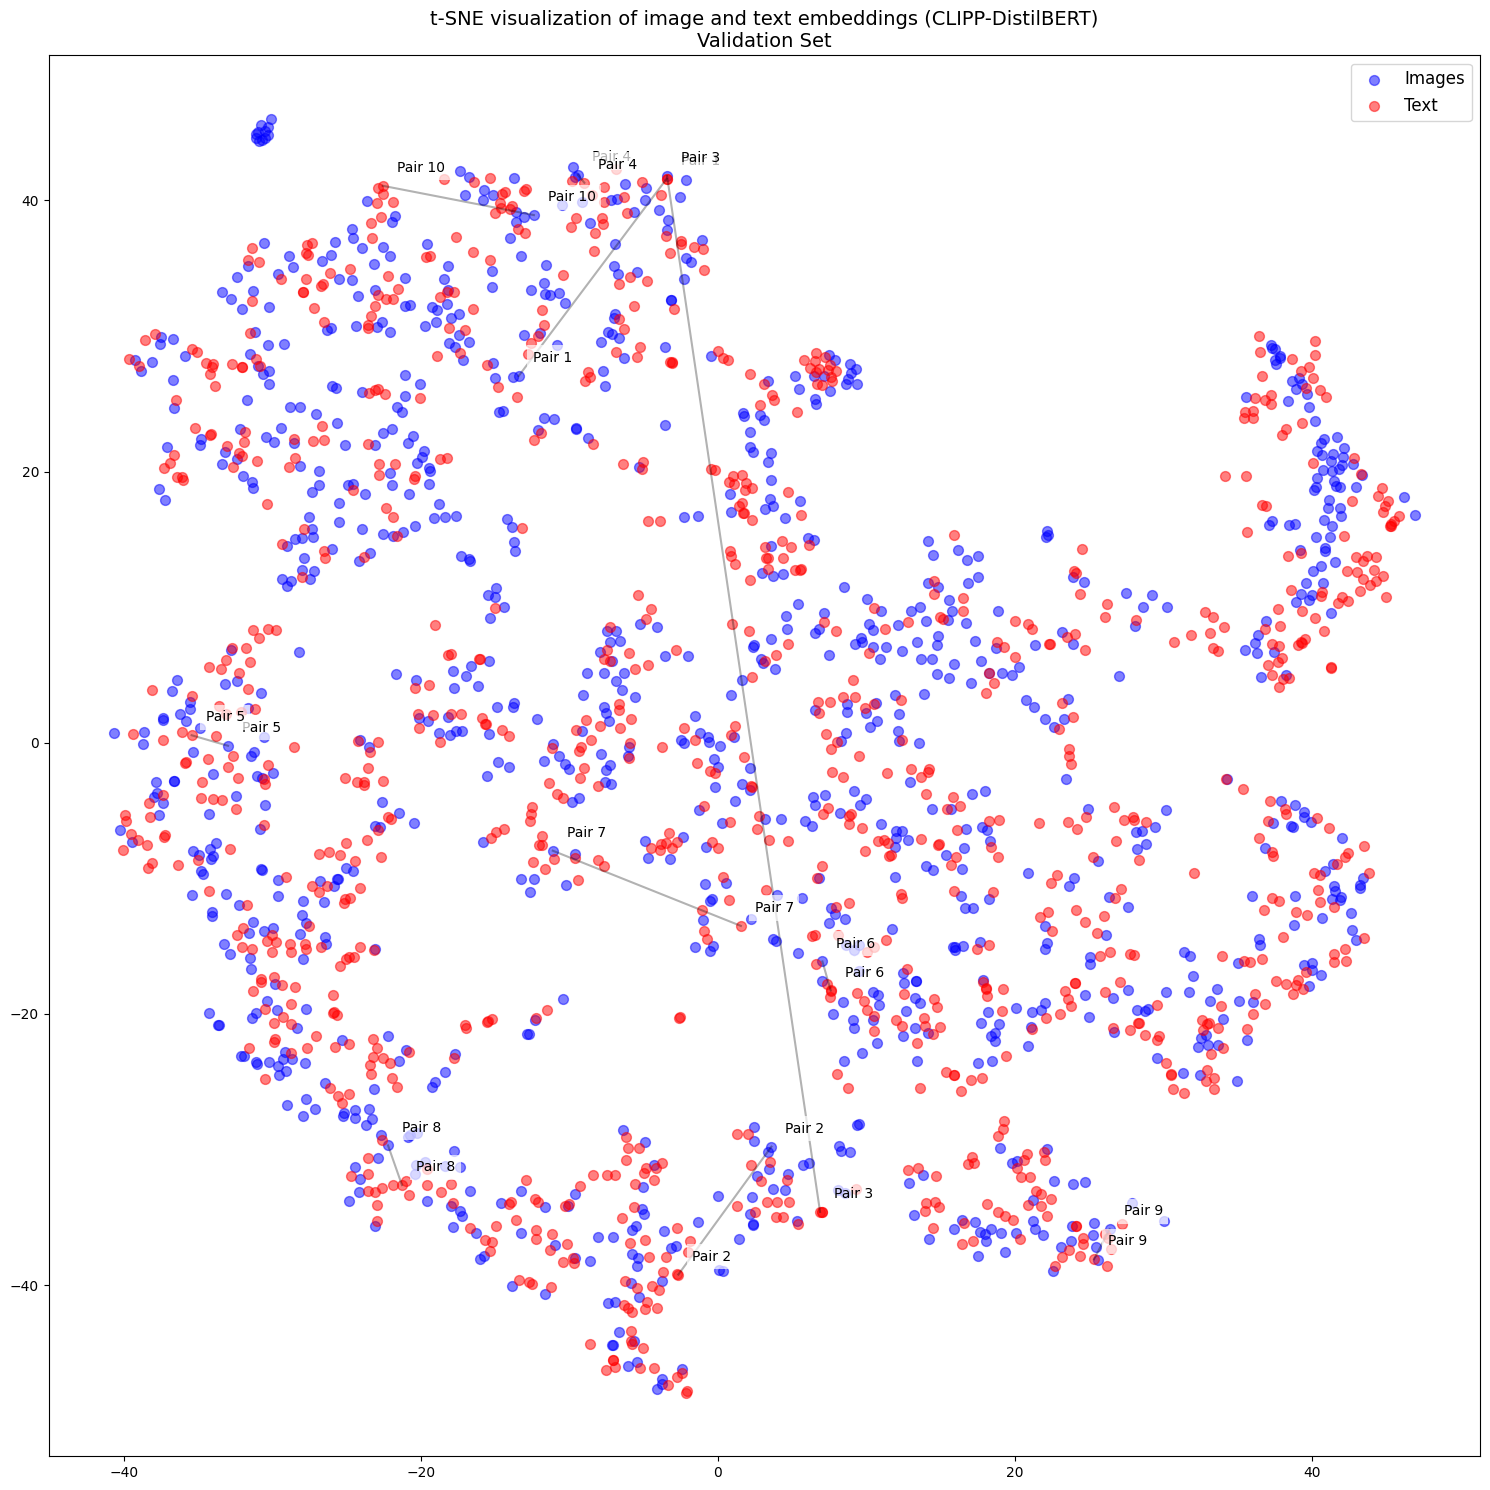

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Only use validation embeddings for visualization
combined_embs = torch.cat([val_img_embs, val_txt_embs], dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
combined_tsne = tsne.fit_transform(combined_embs.numpy())

# Split back into image and text embeddings
n = len(val_img_embs)
img_tsne = combined_tsne[:n]
txt_tsne = combined_tsne[n:]

# Create visualization
plt.figure(figsize=(15, 15))

# Plot all points
plt.scatter(img_tsne[:, 0], img_tsne[:, 1], c='blue', label='Images', alpha=0.5, s=50)
plt.scatter(txt_tsne[:, 0], txt_tsne[:, 1], c='red', label='Text', alpha=0.5, s=50)

# Draw lines connecting corresponding pairs for a subset of examples
num_examples = 10  # Number of example pairs to highlight
random_indices = np.random.choice(n, num_examples, replace=False)

for i, idx in enumerate(random_indices):
    # Draw a line connecting the image-text pair
    plt.plot([img_tsne[idx, 0], txt_tsne[idx, 0]], 
             [img_tsne[idx, 1], txt_tsne[idx, 1]], 
             'k-', alpha=0.3)
    
    # Add number labels
    plt.annotate(f'Pair {i+1}', 
                xy=(img_tsne[idx, 0], img_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'Pair {i+1}', 
                xy=(txt_tsne[idx, 0], txt_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(fontsize=12)
plt.title('t-SNE visualization of image and text embeddings (CLIPP-DistilBERT)\nValidation Set', fontsize=14)

# Add text descriptions for a few example pairs
# plt.figure(figsize=(10, 5))
# plt.axis('off')
# plt.text(0.1, 1.0, 'Example Pair Descriptions:', fontsize=12, fontweight='bold')
# for i, idx in enumerate(random_indices[:5]):  # Show first 5 pairs
#     plt.text(0.1, 0.9 - i*0.2, f'Pair {i+1}: {val_captions[idx][:100]}...', 
#              fontsize=10, wrap=True)

plt.tight_layout()
plt.show()